In [2]:
import copy

from collections import defaultdict

from iq.uniqueness_metric import UniquenessMetric
from nvd_entry import NVDEntry
from solver.regexsolver import RegexSolver
from utils import get_cve_list
from downloader import Downloader

## Create dataset

Create the dataset using the `get_cve_list()` functionality in `src.utils`

### Grab all data

In [3]:
years = list(range(2002, 2020))

nvdfile_data = [NVDEntry(e) for year in range(2002, 2020) for e in get_cve_list(year)]
valid_data = [e for e in nvdfile_data if not e.rejected]

In [4]:
original_db = defaultdict(list)
for e in valid_data:
    original_db[e.year].append(e)

In [5]:
total = sum(len(original_db[y]) for y in original_db)
    
print("Total entries: ", total)
print(original_db.keys())

Total entries:  131541
dict_keys([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])


In [6]:
re = RegexSolver()
solved_entries = re.solve(valid_data)

In [7]:
solved_db = defaultdict(list)
for e in solved_entries:
    solved_db[e.year].append(e)
assert(solved_db.keys() == original_db.keys())

### Evaluation of the Regex-Path-Tagger

In [8]:
with open("../dataset/test.csv", "r") as file:
    id = 0
    ids = []
    for line in file:
        splitted_line = line.split(" ")
        if splitted_line[2] != id and splitted_line[2] != "\n" and splitted_line[2] != "":
            id = splitted_line[2]
            ids.append(id.replace("\n",""))


In [13]:
f = open("VP.txt", "w")
from flair.data import Sentence

for id in ids:
    found = False
    path = []
    for cve in solved_db[int(id[4:8])]:
        if cve.id == id:
            for description in cve.description:
                sentence = Sentence(description, use_tokenizer=True)
                if cve.path != None:
                    path = " ".join(cve.path)
                    path = Sentence(path, use_tokenizer=True)
                    path = [token.text for token in path]
                    
                path_cnt = 0
                for token in (token.text for token in sentence):
                    #if path_cnt < len(path) and token == path[path_cnt]:
                    if token in path:
                        tag = "VP"
                        path_cnt += 1
                    else:
                        tag = "O"
                    f.write(token + " " + tag + " " + cve.id + '\n') 
                    tag = ""
            f.write('\n') 
            found = True
            break
    # Rejected are not found. Assuming the best case, that these 6 entries are tagged correctly
    if not found:
        f.write("** O CVE-2019-4782\nREJECT O CVE-2019-4782\n** O CVE-2019-4782\nDO O CVE-2019-4782\nNOT O CVE-2019-4782\nUSE O CVE-2019-4782\nTHIS O CVE-2019-4782\nCANDIDATE O CVE-2019-4782\nNUMBER O CVE-2019-4782\n. O CVE-2019-4782\nConsultIDs O CVE-2019-4782\n: O CVE-2019-4782\nnone O CVE-2019-4782\n. O CVE-2019-4782\nReason O CVE-2019-4782\n: O CVE-2019-4782\nThis O CVE-2019-4782\ncandidate O CVE-2019-4782\nwas O CVE-2019-4782\nin O CVE-2019-4782\na O CVE-2019-4782\nCNA O CVE-2019-4782\npool O CVE-2019-4782\nthat O CVE-2019-4782\nwas O CVE-2019-4782\nnot O CVE-2019-4782\nassigned O CVE-2019-4782\nto O CVE-2019-4782\nany O CVE-2019-4782\nissues O CVE-2019-4782\nduring O CVE-2019-4782\n2019 O CVE-2019-4782\n. O CVE-2019-4782\nNotes O CVE-2019-4782\n: O CVE-2019-4782\nnone O CVE-2019-4782\n. O CVE-2019-4782\n\n")
f.close()

ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/phil/src/paper/ovana/.devenv/state/venv/lib/python3.11/site-packages/scipy/linalg/__init__.py)

In [ ]:
with open("../dataset/test.csv", "r") as ground_truth_file:
    vp_true_positive, vp_false_positive, vp_false_negative, vp_true_negative = 0,0,0,0
    with open("VP.txt", "r") as predicted_file:
        predicted_lines = predicted_file.readlines()
        for i, ground_truth_line in enumerate(ground_truth_file):
            if ground_truth_line.replace("\n", "").replace(" ", "") == "":
                continue
            predicted_line = predicted_lines[i]
            predicted_tag = predicted_line.split(" ")[1]
            
            if predicted_tag == "VP" and "VP" in ground_truth_line.split(" ")[1]:
                vp_true_positive += 1
            elif predicted_tag == "VP":
                vp_false_positive += 1
            elif predicted_tag == "O" and "VP" in ground_truth_line.split(" ")[1]:
                vp_false_negative += 1
            else:
                vp_true_negative += 1
    

In [ ]:
print(vp_true_positive)
print(vp_false_positive)
print(vp_false_negative)
print(vp_true_negative)

In [ ]:
vp_prec = vp_true_positive/(vp_false_positive + vp_true_positive)
vp_rec = vp_true_positive/(vp_true_positive + vp_false_negative)
vp_f1 = 2 * vp_prec * vp_rec / (vp_prec + vp_rec)

print(vp_prec)
print(vp_rec)
print(vp_f1)

### Preanalyse Data

In [14]:
no_cpe = [entry for y in original_db for entry in original_db[y] if len(entry.cpe) == 0]
print("Affected by problem IV: ", len(no_cpe))
print(no_cpe[:2])

Affected by problem IV:  253
[{'id': 'CVE-1999-0103', 'year': 1999, 'cwe': {'NVD-CWE-Other'}, 'cpe': [], 'cvssv2': AV:N/AV:L/Au:N/C:N/I:N/A:P - [5.0], 'cvssv3': None, 'references': ['https://ics-cert.us-cert.gov/advisories/ICSMA-18-233-01'], 'description': ['Echo and chargen, or other combinations of UDP services, can be used in tandem to flood the server, a.k.a. UDP bomb or UDP packet storm.'], 'rejected': False, 'predicted_cvssv3': None, 'path': None, 'vulnerable_function': None, 'software_name': None, 'software_version': None, 'weakness': None}, {'id': 'CVE-1999-0105', 'year': 1999, 'cwe': {'NVD-CWE-Other'}, 'cpe': [], 'cvssv2': AV:L/AV:L/Au:N/C:N/I:N/A:P - [2.1], 'cvssv3': None, 'references': [], 'description': ['finger allows recursive searches by using a long string of @ symbols.'], 'rejected': False, 'predicted_cvssv3': None, 'path': None, 'vulnerable_function': None, 'software_name': None, 'software_version': None, 'weakness': None}]


In [15]:
print('num entries', len(valid_data))

# Problem I    
no_cwe = [entry for entry in valid_data if len(entry.cwe) == 0]
cwe_other = [entry for entry in valid_data if len(entry.cwe) > 0 and any('NVD-CWE' in e for e in entry.cwe)]
print("No cwe (pI)\t ", len(cwe_other) + len(no_cwe))

# Problem II
old_cvss = [entry for entry in valid_data if not entry.cvssv3]
new_cvss = [entry for entry in valid_data if entry.cvssv3]
print('Old cvss (pII)\t ', len(old_cvss))

# Problem III
path_found = [entry for entry in solved_entries if entry.path or entry.vulnerable_function]
print('Path found (pIII)', len(path_found))
print([e.path for e in solved_entries if e.path][:100])

# Problem IV
no_cpe = [entry for entry in valid_data if not len(entry.cpe)]
print("No cpe (pIV)\t ", len(no_cpe))

num entries 131541
No cwe (pI)	  36761
Old cvss (pII)	  73647
Path found (pIII) 46713
[['ip_input.c'], ['rpc.ttdbserverd'], ['rpc.nisd'], ['rpc.statd'], ['Count.cgi'], ['webdist.cgi'], ['php.cgi'], ['rpc.pcnfsd'], ['convert.bas'], ['sample.exe'], ['in.rshd'], ['newdsn.exe'], ['in.comsat'], ['rpc.ypupdated'], ['rpc.mountd'], ['LSASS.EXE'], ['RPCSS.EXE'], ['php.cgi'], ['pfdispaly.cgi'], ['rpc.cmsd'], ['rpc.pcnfsd'], ['reboot.ini'], ['ff.core'], ['advsearch.asp', 'query.asp', 'search.asp'], ['perl.exe'], ['bugtraq/1999/Jan/0215.html', 'seclists.org'], ['exprcalc.cfm'], ['rguest.exe', 'wguest.exe'], ['Remote.NLM'], ['openfile.cfm'], ['MSHTML.DLL'], ['MSHTML.DLL'], ['rpc.statd'], ['etc/hosts.equiv'], ['rpc.admind'], ['index.html'], ['PASSFILT.DLL'], ['web_store.cgi'], ['mall2000.cgi'], ['quikstore.cfg', 'quikstore.cgi'], ['shopper.cgi'], ['SoftCart.exe'], ['rpc.sprayd'], ['rpc.rquotad'], ['scriptlet.typelib'], ['rpc.cmsd'], ['dialer.exe', 'dialer.ini'], ['cachemgr.cgi'], ['showcode.asp'], [

In [16]:
original_year_clusters = dict()
solved_year_clusters = dict()
original_scores_by_year = dict()
solved_scores_by_year = dict()

um = UniquenessMetric(['cwe', 'cpe', 'cvssv3', 'path'])

for year in original_db.keys():
    original_year_clusters[year] = um.build_clusters(original_db[year])
    solved_year_clusters[year] = um.build_clusters(solved_db[year])
    original_scores_by_year[year] = um.score(original_db[year])
    solved_scores_by_year[year] = um.score(solved_db[year])

In [17]:
print(original_year_clusters.keys())
year = next(iter(original_year_clusters))

print(list(original_year_clusters[year].keys())[:5]) # hashes
single_hash = next(iter(original_year_clusters[year]))

cluster = original_year_clusters[year][single_hash]
print(len(cluster))
print(type(cluster[0]))
print(cluster[0].id)
#for c in original_year_clusters[year].values():
#    print(len(c))
    
print(list(original_scores_by_year.items()))
print(list(solved_scores_by_year.items()))
print(list(zip(original_scores_by_year.values(), solved_scores_by_year.values())))

dict_keys([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
['{"cpe": [{"cpe_match": [{"cpe23Uri": "cpe:2.3:o:bsdi:bsd_os:3.1:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:1.0:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:1.1:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:1.1.5.1:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:1.2:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:2.0:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:2.0.1:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:2.0.5:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:2.1.5:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:2.3:o:freebsd:freebsd:2.1.6:*:*:*:*:*:*:*", "vulnerable": true}, {"cpe23Uri": "cpe:

## Clusters by Size

In [18]:
import collections

def cluster_by_size(year_clusters: dict):
    clusters_by_size_dict = collections.defaultdict(list)
    for cluster in year_clusters.values():
        clusters_by_size_dict[len(cluster)].append(cluster)
    return clusters_by_size_dict

original_cluster_size_dict = {year:cluster_by_size(original_year_clusters[year]) for year in original_year_clusters}
solved_cluster_size_dict = {year:cluster_by_size(solved_year_clusters[year]) for year in solved_year_clusters}

In [19]:
import random

year = random.randint(2002, 2019)

print(sorted(original_cluster_size_dict.keys()))

print(year)
print(sorted(original_cluster_size_dict[year].keys()))
for size in sorted(original_cluster_size_dict[year]):
    print(f'{size:2}: {len(original_cluster_size_dict[year][size]):5}')

[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
2010
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 20]
 1:  3799
 2:   285
 3:    71
 4:    31
 5:     9
 6:     6
 7:     9
 8:     3
 9:     3
10:     3
11:     2
12:     2
13:     1
16:     1
20:     1


In [20]:
tmp = -1

ids = [entry.id for entry in original_cluster_size_dict[year][sorted(original_cluster_size_dict[year].keys())[tmp]][0]]
print(len(ids), ', '.join(ids))
original_cluster_size_dict[year][sorted(original_cluster_size_dict[year].keys())[tmp]][0]

20 CVE-2010-2160, CVE-2010-2162, CVE-2010-2165, CVE-2010-2166, CVE-2010-2167, CVE-2010-2169, CVE-2010-2171, CVE-2010-2173, CVE-2010-2174, CVE-2010-2175, CVE-2010-2176, CVE-2010-2177, CVE-2010-2178, CVE-2010-2180, CVE-2010-2182, CVE-2010-2184, CVE-2010-2185, CVE-2010-2187, CVE-2010-2188, CVE-2010-2189


[{'id': 'CVE-2010-2160', 'year': 2010, 'cwe': {'CWE-119'}, 'cpe': [{'operator': 'OR', 'cpe_match': [{'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.16:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.20:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.20.0:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.28:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.28.0:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.31:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.31.0:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.45.0:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.47.0:*:*:*:*:*:*:*'}, {'vulnerable': True, 'cpe23Uri': 'cpe:2.3:a:adobe:flash_player:9.0.48.0:*:*:*:*:*:*:*'}, {'vulnerable': Tru

### Findings of manual analysis of the cluster in 2019:

- Some descriptions contain errors: Android ID should be Android Bug ID (e.g., CVE-2019-2061 until CVE-2019-2078)
- Libraries are accounted for as part of android, while they should be products on their own (e.g. libvpx, now owned by google has cpe ID `cpe:2.3:o:google:android:10.0:*:*:*:*:*:*:*` while there exists `cpe:2.3:a:webmproject:libvpx:-:*:*:*:*:*:*:*` [1]. Introduction of `cpe:2.3:a:google:libvpx:-:*:*:*:*:*:*:*` with the according version could resolve these clusters (e.g., CVE-2019-9232, CVE-2019-9250) 
- Some clusters miss `cwe` and `cpe` information (e.g., CVE-2019-0235, CVE-2019-15874, CVE-2019-16011)
- Some vulns distinguish themselves explicitly in the description using other CVE-IDs, while the machine readable information remain the same (e.g. 'CVE-2019-0889', 'CVE-2019-0890', 'CVE-2019-0891', 'CVE-2019-0893', 'CVE-2019-0894', 'CVE-2019-0895', 'CVE-2019-0896', 'CVE-2019-0897', 'CVE-2019-0898', 'CVE-2019-0899', 'CVE-2019-0900', 'CVE-2019-0901', 'CVE-2019-1146', 'CVE-2019-1147', 'CVE-2019-1156', 'CVE-2019-1157', 'CVE-2019-1240', 'CVE-2019-1241', 'CVE-2019-1242', 'CVE-2019-1243', 'CVE-2019-1247', 'CVE-2019-1248', 'CVE-2019-1249', 'CVE-2019-1250', 'CVE-2019-1358', 'CVE-2019-1359'). Moreover these vulns use microsoft operating systems as product, while the vulnerability resides in the Windows Jet Database Engine.
- Some vulnerabilities are batch-added (CVE-2019-7762, CVE-2019-7763, CVE-2019-7764, CVE-2019-7765, CVE-2019-7766, CVE-2019-7767, CVE-2019-7768, CVE-2019-7772, CVE-2019-7781, CVE-2019-7782, CVE-2019-7783, CVE-2019-7788, CVE-2019-7791, CVE-2019-7792, CVE-2019-7805, CVE-2019-7806, CVE-2019-7807, CVE-2019-7808, CVE-2019-7832, CVE-2019-7833, CVE-2019-7834, CVE-2019-7835)
- In its current form, the CPE is hardy used for its full potential (CVE-2019-8010: `cpe:2.3:a:adobe:acrobat_reader_dc:*:*:*:*:classic:*:*:*` misses the versions)
- Old CVEs (especially in 2002) omit specific `cwe` classes and use `NVD-CWE-Other` instead

1: https://nvd.nist.gov/products/cpe/search/results?namingFormat=2.3&keyword=libvpx

## Import plotting libraries

In [21]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.colors as colors

## Prepare Plot

Use the `data` dict to prepare plotting data.
Define before solving data `old` and after solving data `new`.
Adjust scales `max_old, max_new, max_all` and grab colormap and normalization function.

### Plot data for original data

Iterate over the size dicts and create for each possible clustersize a list with the sizes per year, e.g. `[0] * len(years)` would be result for the clustersize `0` since for all clusters `c` `len(c) > 0`. This analysis starts with clustersize 2, because clustersize 1 would distort the plot to much.

/tmp/ipykernel_35120/101381343.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


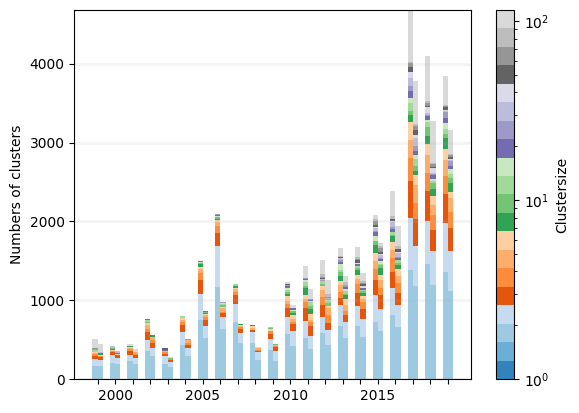

In [23]:
xticklabels = [label if int(label) % 5 == 0 else '' for label in original_db]
max_cluster_size_original = max(size for year in original_cluster_size_dict for size in original_cluster_size_dict[year].keys())
max_cluster_size_solved = max(size for year in solved_cluster_size_dict for size in solved_cluster_size_dict[year].keys())
max_all = max(max_cluster_size_original, max_cluster_size_solved)

fig, ax = plt.subplots()
x = np.arange(len(xticklabels))  # label locations
width = 0.3  # the width of the bars

# colormap and normalization function
cmap = cm.get_cmap('tab20c')
norm = colors.LogNorm(vmin=1, vmax=max_all)

# plot original cluster sizes
before_original = np.zeros(len(original_cluster_size_dict))
for cluster_size in range(2, max_cluster_size_original + 1):
    data = [len(size_dict.get(cluster_size, []))*cluster_size for size_dict in original_cluster_size_dict.values()]
    if any(data):
        ax.bar(x - width / 2, data, width, bottom=before_original, color=cmap(cluster_size))
        before_original += data
        
        
# plot solved cluster sizes
before_solved = np.zeros(len(solved_cluster_size_dict))
for cluster_size in range(2, max_cluster_size_solved + 1):
    data = [len(size_dict.get(cluster_size, []))*cluster_size for size_dict in solved_cluster_size_dict.values()]
    if any(data):
        ax.bar(x + width / 2, data, width, bottom=before_solved, color=cmap(cluster_size))
        before_solved += data
        
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Numbers of clusters')
ax.set_xticks(x)
ax.set_xticklabels(xticklabels)

plt.grid(linestyle='-', linewidth=2, axis='y', alpha=0.15)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Clustersize')

plt.savefig("plot_allyears_multiplied_nonunique.pdf")

# Appendix

In [ ]:
from flair.data import Sentence

f = open("../dataset/all_cves.json", "w")
for year in original_db:
    for entry in original_db[year]:
        sentence = Sentence(entry.description[0], use_tokenizer=True)
        for token in (token.text for token in sentence):
            f.write(token + " " + entry.id + '\n')         
f.close()